## Metropolis Sampler, From the 1953 Paper.




In [1]:
import jax.numpy as jnp
from jax import vmap, grad
import matplotlib.pyplot as plt
from jax.random import uniform, normal, PRNGKey, split

def dist(A, B):
    # Find closest periodic distance between A and B
    d1 = ((A[0]-B[0] + 0.5)%1) - 0.5
    d2 = ((A[1]-B[1] + 0.5)%1) - 0.5
    return (d1**2 + d2**2)**0.5

def find_closest(A, B):
    # Find closest version of particle (for visualization only)
    d1 = ((A[0]-B[0] + 0.5)%1) - 0.5
    d2 = ((A[1]-B[1] + 0.5)%1) - 0.5
    return B[0] + d1, B[1] + d2

def rejection_sampling(key, N, r, dmin=0):
    coord_list = []
    successes = 0
    while successes < N:
        key, skey = split(key, 2)
        coord = uniform(skey, (2,), minval=-0.5, maxval=0.5)
        dists = [dist(coord, c) for c in coord_list] + [3.]
        if min(dists)-2*r>dmin:
            coord_list.append(coord)
            successes += 1
        else:
            pass
    return jnp.array(coord_list)

def initialize():
    c1 = jnp.arange(14) * 1/14
    c2 = jnp.arange(16) * 1/16
    
    C1 = c1[None, :] + (jnp.arange(16)%2==1)[:, None] * 0.5 / 14 - 0.5
    C2 = c2[:, None] + jnp.zeros(14)[None, :] - 0.5
    return jnp.concatenate([C1.flatten()[:,None], C2.flatten()[:,None]], 1) #jnp.concatenate([C1[:,:,None], C2[:,:,None]], axis=2).reshape(-1, 2)[:10]
    

def plot_circle(coord, r, fillcolor=None, **kwargs):
    t = jnp.linspace(0,2*jnp.pi,100)
    cost = jnp.cos(t)
    sint = jnp.sin(t)
    plt.plot(cost*r + coord[0], sint*r + coord[1], **kwargs)
    if fillcolor is not None:
        plt.fill(cost*r + coord[0], sint*r + coord[1], color=[float(c) for c in fillcolor])

def plot_circles(coords, r, fillcolors, **kwargs):
    if fillcolors is None:
        fillcolors = jnp.ones((len(coords), 3))
    for c,fc in zip(coords, fillcolors):
        plot_circle(c, r, fillcolor=fc, **kwargs)
        
def plot_box(**kwargs):
    plt.plot([-0.5,0.5,0.5,-0.5,-0.5],[-0.5,-0.5,0.5,0.5,-0.5],**kwargs)
        
def plot_circle_distances(coords, r, **kwargs):
    for c1 in coords:
        for c2 in coords:
            c2c1 = find_closest(c2, c1)
            if max([abs(c) for c in c2c1]) > 0.5:
                plot_circle(c2c1, r, color="grey", **kwargs)
                plt.plot([c2c1[0], c1[0]], [c2c1[1], c1[1]], color="red", **kwargs)
    
def V(d, r):
    # Potential energy function
    return jnp.where(d>2*r, 0., jnp.inf)
    
def V_mat(Vfunc, coords):
    V_dists = vmap(lambda y: vmap(lambda x: Vfunc(dist(x,y)), 0)(coords), 0)(coords)
    return V_dists

def propose_move(key, step):
    # Propose a move for a particle
    #dx0 = normal(key, (2,)) * step
    dx0 = uniform(key, (2,), minval=-step, maxval=step) # Propose a step
    return dx0
    
def make_move(x, dx0, idx0):
    # Move particle idx0 by dx0
    x = x.at[idx0].set(((x[idx0] + dx0+0.5)%1) - 0.5)
    return x

def MH_step(key, x, dx0, idx0, dEval, kT):
    # Metropolis-Hastings step
    p = jnp.exp(-dEval/kT)
    u = uniform(key, (1,))
    return x if u > p else make_move(x, dx0, idx0)

def MH_step_vec(Vfunc, u, x, mask, x0, x1, r, kT):
    # Metropolis-Hastings step
    pot = lambda x, y: Vfunc(dist(x,y), r)
    E0 = jnp.where(mask, vmap(pot, (0, None))(x, x0), jnp.zeros(len(x))).sum()
    E1 = jnp.where(mask, vmap(pot, (0, None))(x, x1), jnp.zeros(len(x))).sum()
    p = jnp.exp(-(E1 - E0)/kT)
    return jnp.where(u > p, x0, x1)

def run_cycle_vec(key, Vfunc, x, r, step, kT):
    # Run a cycle of Metropolis-Hastings
    key, keyu, keys = split(key, 3)
    u = uniform(keyu, (len(x),))
    x1 = ((x + normal(keys, (len(x), 2)) * step + 0.5) % 1) - 0.5 # Propose a step
    mask = jnp.eye(len(x))
    
    mh_step = lambda u, m, x0, x1: MH_step_vec(Vfunc, u, x, m, x0, x1, r, kT)
    x = vmap(mh_step, (0, 0, 0, 0))(u, mask, x, x1)
    return x
    

def run_cycle(key, Vfunc, x, r, step, kT):
    for idx0 in range(len(x)):
        key, skey, skey2 = split(key, 3)
        dx0 = propose_move(skey, step)
        dE_val = dE(Vfunc, x, dx0, idx0, r)
        x = MH_step(skey2, x, dx0, idx0, dE_val, kT)
    return x

def run_cycles(key, Vfunc, x, r, step, kT, ncycles, nburn=0):
    # Run ncycles of Metropolis-Hastings
    xhist = []
    for i in range(ncycles+nburn):
        key, skey = split(key)
        x = run_cycle(skey, Vfunc, x, r, step, kT)
        print(f"Cycle {i+1}/{ncycles+nburn}.", end="\r")
        if i < nburn:
            pass
        else:
            xhist.append(x)
    return xhist

def dE(Vfunc, x, dx0, idx0, r):
    # Difference in energy before and after moving particle
    # dx0 is the change in position of particle idx0
    idx = jnp.arange(len(x))
    pot = lambda x, y: Vfunc(dist(x,y), r)
    E0 = vmap(pot, (0, None))(x[idx!=idx0], x[idx0]).sum()
    E1 = vmap(pot, (0, None))(x[idx!=idx0], x[idx0] + dx0).sum()
    return E1 - E0


# Parameters
N = 224 # Particles
M = 64 # Bins
kT = 1.
d = 1/14
nu = 5
K = 1.5

# Variables
r = d*(1-2**(nu-8))/2
d0 = 2*r
step = d - d0
AdivA0 = 1/(0.98974329*(1-2**(nu-8))**2) #1/(3**0.5*d0**2*N/2)
dA2 = (K**2 - 1)*jnp.pi*(d0**2)/M

# 

# MH parameters
ncycles = 64
nburn = 16

I0000 00:00:1746541921.022849    9619 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(-0.5841479480266571,
 0.5799530923366547,
 -0.5842935144901276,
 0.5827503502368927)

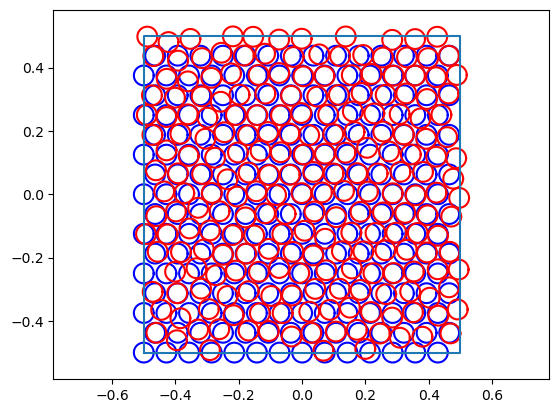

In [2]:
x0 = initialize()
xhist = run_cycles(PRNGKey(1), V, x0, r, step, kT, ncycles, nburn)
plot_circles(x0, r, fillcolors=None, color="blue")
plot_circles(xhist[-1], r, fillcolors=None, color="red")
plot_box()
plt.axis("equal")

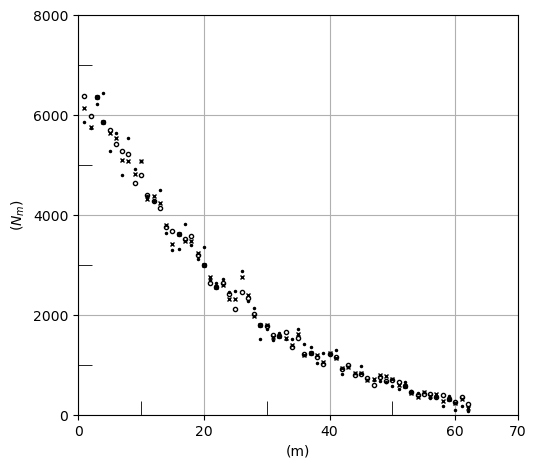

In [4]:
def create_distance_histogram(xhist, dA2, d0, M, N):
    # For each cycle, compute pairwise distances and add to histogram bins
    mhist = []
    for n in range(N):
        z = xhist[n]
        pir2_vec = vmap(lambda x: vmap(lambda y: dist(x,y), 0)(z), 0)(z)
        pir2_vec = pir2_vec.flatten()**2 * jnp.pi
        m_vec = jnp.floor((pir2_vec - jnp.pi*d0**2)/dA2)
        m_vec = jnp.clip(m_vec, 0, M-1)
        m_vec = m_vec.astype(int)
        mhist.append(m_vec)
        
    mhist = jnp.concatenate(mhist)
    mhist = jnp.bincount(mhist, minlength=M)/N/2
    return mhist, jnp.arange(M)

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
          



s = 1/224 # Scaling factor


fig, ax=plt.subplots()

for label, fc, N in zip([".", "x", "o"], ["black", "none", "none"], [16, 32, 48]):
    Nm, m = create_distance_histogram(xhist, dA2, d0, M, N)
    plt.plot(m[1:-1], Nm[1:-1], label, color="black", markersize=3, markeredgecolor="black", markerfacecolor=fc) 

plt.tick_params(axis="y", which="minor", direction="in", length=10)
plt.tick_params(axis="x", which="minor", direction="in", length=10)
plt.xticks([0, 20, 40, 60, 70], [0, 20, 40, 60, 70])
plt.xticks([10, 30, 50], minor=True)
yticks = [0, s*2000, s*4000, s*6000, s*8000]
minor_yticks = [s*1000, s*3000, s*5000, s*7000]
plt.yticks(minor_yticks, minor=True)
plt.yticks(yticks, [f"{y/s:.0f}" for y in yticks])

plt.grid()
plt.xlim([0, 70])
plt.ylim([0, s*8000])
plt.xlabel("(m)")
plt.ylabel("$(N_m)$")#, rotation="horizontal")

set_size(4*1.1, 4, ax=ax)

plt.savefig("/home/emastr/github/multireference-alignment/notebooks/side_projects/figures/metropolis_figure_5_recreation.png", dpi=300, bbox_inches="tight")




In [21]:
m_lin = m[1:17]
Nm_lin = Nm[1:17]

# Fit line to data
X = jnp.vstack([m_lin, jnp.ones(len(m_lin))]).T
Y = Nm_lin
A = jnp.linalg.lstsq(X, Y, rcond=None)[0]
slope, intercept = A[0], A[1]
print(f"Slope: {slope}, Intercept: {intercept}")

Nhalf = 0.5 * slope + intercept
PA_NkT_1 = 64*(Nhalf/s)/(224**2)/(K**2-1)#/N**2#/(K**2 - 1)*10 # scale byh 10??
print(f"Nhalf: {Nhalf /s}, (PA/NkT)-1: {PA_NkT_1}")


Slope: -0.870374321937561, Intercept: 29.555734634399414
Nhalf: 6523.00244140625, (PA/NkT)-1: 6.656125068664551


In [4]:
def create_anim(xhist, r, nframes=256):
    N = len(xhist)
    white = jnp.array([1., 1., 1.])
    greenblue = jnp.array([0., 1., 1.])
    for n in range(nframes):
        hist_idx = jnp.floor(n/nframes * N).astype(int)
        x0 = xhist[hist_idx]
        x1 = xhist[hist_idx+1] if hist_idx+1 < N else xhist[0]
        t = (n/nframes*N - hist_idx)
        delta = vmap(dist, 0, 0)(x0,x1)
        delta_jump = jnp.linalg.norm(x0-x1, axis=1)
        color = white[None, :] - greenblue[None, :] * delta[:, None] * 4*t*(1-t) / 0.05
        x = jnp.where((delta_jump<0.5)[:,None], x0 + (x1-x0) * t, x1) # Interplate if no jump
        
        fig = plt.figure(figsize=(4, 4))
        plot_circles(x, r, fillcolors=color, color="black", linewidth=1.)
        plot_box(linewidth=0.5, color="black", linestyle="--")
        plt.axis("equal")
        plt.axis("off")
        plt.xlim([-0.55, 0.55])
        plt.ylim([-0.55, 0.55])
        
        #plot_circle_distances(x, r)
        
        fig.savefig(f"/home/emastr/github/multireference-alignment/notebooks/side_projects/figures/anim/metropolis_figure_5_recreation_{n:03d}.png", dpi=300, bbox_inches="tight")
        print(f"Frame {n+1}/{nframes}, idx={hist_idx}, t={t}, t2={(1-4*t*(1-t))}.", end="\r")
        plt.close()

nframes = 256
create_anim(xhist, r, nframes=nframes)
        

In [ ]:
import imageio
nframes = 256
images = []
filenames = [f"/home/emastr/github/multireference-alignment/notebooks/side_projects/figures/anim/metropolis_figure_5_recreation_{n:03d}.png" for n in range(nframes)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/home/emastr/github/multireference-alignment/notebooks/side_projects/figures/movie.gif', images)

/tmp/ipykernel_20717/647992730.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [ ]:

#plt.figure(figsize=(15,5))
#plt.subplot(131)
#plot_circles(x, r, color="blue")
#plot_circle_distances(x, r)
#plot_box()
#plt.axis("equal")

#plt.subplot(132)
#plot_circles(x, r, color="blue")
#plot_box()
#plt.axis("equal")

#plt.subplot(133)
#x_new = run_cycle(PRNGKey(0), V, x, r, step, kT)
#plot_circles(x, r, color="blue")
#plot_circles(x_new, r, color="red")
#plot_box()
#plt.axis("equal")